## **Importing and Understanding Data**
# **Model Selection using RFE(HOUSING CASE STUDY)**

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Housing.csv to Housing.csv


In [3]:
# Importing Housing.csv
housing = pd.read_csv('Housing.csv')

In [4]:
# Looking at the first five rows
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### **Data Preparation**

In [5]:
# Converting Yes to 1 and No to 0
housing['mainroad'] = housing['mainroad'].map({'yes': 1, 'no': 0})
housing['guestroom'] = housing['guestroom'].map({'yes': 1, 'no': 0})
housing['basement'] = housing['basement'].map({'yes': 1, 'no': 0})
housing['hotwaterheating'] = housing['hotwaterheating'].map({'yes': 1, 'no': 0})
housing['airconditioning'] = housing['airconditioning'].map({'yes': 1, 'no': 0})
housing['prefarea'] = housing['prefarea'].map({'yes': 1, 'no': 0})

In [6]:
# Creating dummy variable for variable furnishingstatus and dropping the first one
status = pd.get_dummies(housing['furnishingstatus'],drop_first=True)

In [7]:
#Adding the results to the master dataframe
housing = pd.concat([housing,status],axis=1)

In [8]:
# Dropping the variable 'furnishingstatus'
housing.drop(['furnishingstatus'],axis=1,inplace=True)

### **Creating a new variable**

In [9]:
# Let us create the new metric and assign it to "areaperbedroom"
housing['areaperbedroom'] = housing['area']/housing['bedrooms']

In [10]:
# Metric: bathrooms per bedroom
housing['bbratio'] = housing['bathrooms']/housing['bedrooms']

## **Rescaling the Features**
It is extremely important to rescale the variables so that they have a comparable scale. There are twocoon ways of rescaling

1. Normalisation (min-max scaling) and
2. standardisation (mean-o, sigma-1) Let's try normalisation

In [11]:
#defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                            
                                              
# applying normalize ( ) to all columns 
housing = housing.apply(normalize)

### **Splitting data into training and testing sets**

In [12]:
# Putting feature variable to X
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio']]

# Putting response variable to y
y = housing['price']

In [14]:
!pip install -U scikit-learn

In [16]:
#random_state is the seed used by the random number generator, it can be any integer.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

In [17]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### **RFE**

In [18]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [26]:
# Running RFE with the output number of the variable equal to 9
lm = LinearRegression()
rfe = RFE(lm)             # running RFE
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)

[ True False  True  True False False False  True  True False False False
 False  True  True]
[1 5 1 1 2 6 8 1 1 4 3 9 7 1 1]


In [27]:
col = X_train.columns[rfe.support_]

### **Building model using sklearn**

In [28]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [29]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [31]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     83.63
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           1.57e-72
Time:                        04:17:37   Log-Likelihood:                 343.62
No. Observations:                 381   AIC:                            -671.2
Df Residuals:                     373   BIC:                            -639.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0566      0.020     

In [32]:
# Calculating Vif value
vif_cal(input_data=housing.drop(['area','bedrooms','stories','basement','semi-furnished','areaperbedroom'], axis=1), dependent_col="price")

,Var,Vif
8,bbratio,6.21
1,mainroad,4.66
0,bathrooms,2.78
5,parking,1.82
4,airconditioning,1.59
7,unfurnished,1.44
6,prefarea,1.41
2,guestroom,1.28
3,hotwaterheating,1.08


### **Making Predictions**

In [33]:
# Now let's use our model to make predictions.

# Creating X_test_6 dataframe by dropping variables from X_test
X_test_rfe = X_test[col]

# Adding a constant variable 
X_test_rfe = sm.add_constant(X_test_rfe)

# Making predictions
y_pred = lm.predict(X_test_rfe)

### **Model Evaluation**

In [34]:
# Now let's check how well our model is able to make predictions.

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0, 0.5, 'Housing Price')

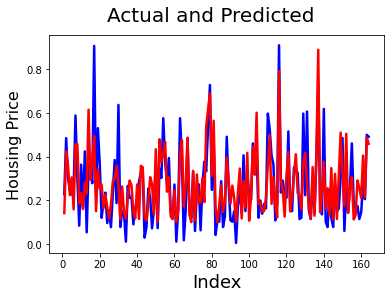

In [35]:
# Actual and Predicted
import matplotlib.pyplot as plt
c = [i for i in range(1,165,1)] # generating index 
fig = plt.figure() 
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Housing Price', fontsize=16)                       # Y-label

Text(0, 0.5, 'ytest-ypred')

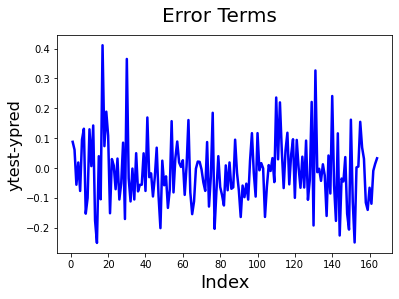

In [36]:
# Error terms
c = [i for i in range(1,165,1)]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label

Text(0, 0.5, 'y_pred')

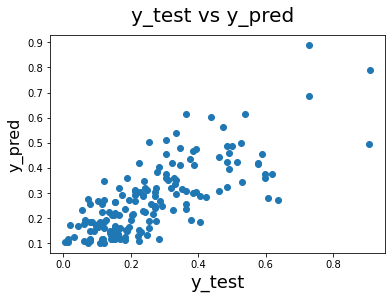

In [37]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Index')

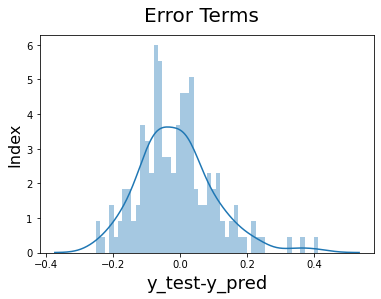

In [38]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

In [39]:
# Now let's check the Root Mean Square Error of our model.
import numpy as np
from sklearn import metrics
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.11299295763927995
